# Markov Chain Monte Carlo aplicado a la energía oscura

Los métodos de **Markov Chain Monte Carlo (MCMC)** son un tipo de algoritmos usados para muestrear distribuciones de probabilidad y evaluar incertidumbres con precisión. En este trabajo se utilizan estos métodos para proporcionan estimaciones de los parámetros cosmológicos clave, como el parámetro de Hubble y la densidad de materia y energía en el universo.

## Conceptos importantes:
 - Cadena de Markov: Proceso cuyo futuro depende únicamente del estado actual, y no de los anteriores
 - Metrópolis-Hastings: Genera nuevas muestras mediante propuestas aleatorias y acepta o rechaza estas muestras con cierta probabilidad que depende de la distribución objetivo

Importamos las paqueterías a usar

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import pandas as pd

Veamos una gráfica. Importamos ahora los datos

In [2]:
dataHz = pd.read_csv("/home/akesito/Documents/Servicio Social/Códigos/Datos/hubble_parameter_data.txt", sep=' ', header=None)

Separamos ahora los datos: **redshift**, **observaciones** y **errores**

In [3]:
redshift, obs, errors = [dataHz[i] for i in range(0,3)]

Graficamos primero los datos observacionales:

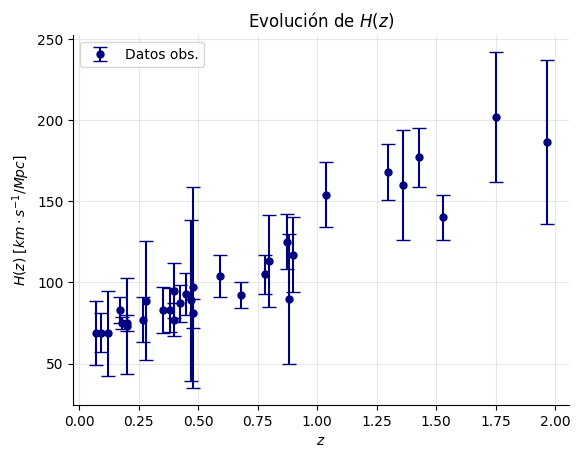

<Figure size 640x480 with 0 Axes>

In [4]:
zvals = np.linspace(0,2.2,220)
plt.errorbar(redshift,obs, yerr=errors, fmt='o',capsize=5, color='navy',ms=5, label="Datos obs.")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(color='lightgray',alpha=0.5,zorder=1)

plt.ylabel("$H(z)$ [$km \\cdot s^{-1}/Mpc$]")
plt.xlabel("$z$")
plt.legend()
plt.title("Evolución de $H(z)$")
plt.show()
plt.savefig("Datos_observacionales.png")

Podemos escribir $H$ usando la (1ra) ec. de Friedmann en el modelo $\Lambda$-CDM:
$$ H^{2} = \frac{8\pi G}{3}\rho - \frac{kc^{2}}{a^{2}} + \frac{\Lambda c^{2}}{3} $$
y definiendo el parámetro de densidad
$$ \rho_{c} = \frac{3H_{0}^{2}}{8\pi G} $$
$$\Omega_{m} = \frac{8\pi G}{3H_{0}^{2}}\rho_{m0} $$
$$ \Omega_{k} = \frac{-kc^{2}}{(a_{0}H_{0})^{2}}  $$
$$ \Omega_{\Lambda} = \frac{\Lambda c^{2}}{3H_{0}^{2}}$$
Podemos reescribir entonces la 1ra ec. de Friedmann como
$$ H(z)^{2} = H_{0}^{2}\left(\Omega_{m}(1+z)^{3}+\Omega_{k}(1+z)^{2} + \Omega_{\Lambda} \right) $$
Actualmente, se asume que $\Omega_{k}=0$, por lo que la ec. nos queda
$$ H(z)^{2} = H_{0}^{2}\left( \Omega_{m}(1+z)^{3} + (1-\Omega_{m} ) \right) $$

Con esto, empezamos definiendo nuestros valores de densidad

In [5]:
H_0 = 0.75 #Valor inicial (km/s)/Mpc 
Ω_m = 0.32 #Densidad de materia
Ω_k = 0.0 #Densidad de curvatura
Ω_de = 1 - Ω_m - Ω_k #Densidad de la energía oscura
Ω_r = 0.0001 # Densidad de radiación

Usando esto definimos nuestra función H(z):

In [6]:
def H(z):
    return  Ω_r*(1+z)**4 + Ω_m*(1+z)**3 + Ω_k*(1+z)**2 + Ω_de*(1-Ω_m)

## El protagonista: Metrópolis-Hastings

In [7]:
def chi_squared(model, current_state, observed_points, inv_cov):
    redshift, d_observed = observed_points
    diff = model(current_state)(redshift) - d_observed
    return diff @ inv_cov @ diff 

In [8]:
def likelihood(chi2):
    return np.exp(-chi2 / 2)

In [9]:
def updater(chain, current_state, proposal_std, current_likelihood, likelihood, model, observed_points, inv_cov):
    proposed_state = np.random.normal(current_state, proposal_std)
    proposed_likelihood = likelihood(chi_squared(model, proposed_state, observed_points, inv_cov))#(model, proposed_state, observed_points, inverse_covariance_matrix)
    accept_criterion = proposed_likelihood / current_likelihood

    if proposed_likelihood >= current_likelihood or np.random.rand() < proposed_likelihood / current_likelihood:
        return proposed_state, proposed_likelihood

    return current_state, current_likelihood

In [10]:
def metropolis_hastings(n_steps, initial_parameters, proposal_std, model, observed_points, covariance_matrix):
    chain = []
    inv_cov = np.linalg.inv(covariance_matrix)
    current_state = initial_parameters
    current_likelihood = likelihood(chi_squared(model, current_state, observed_points, inv_cov))
    
    #current_likelihood = likelihood(model, current_state, observed_points, inv_cov)

    for _ in range(n_steps):
        current_state, current_likelihood = updater(chain, current_state, proposal_std, current_likelihood, likelihood, model, observed_points, inv_cov)
        chain.append(current_state)
    return chain

## Modelo $\Lambda$-CDM

$$ H(z)^{2} = H_{0}^{2}\left(\Omega_{m}(1+z)^{3} + (1-\Omega_{m} \right)(1+z)^{3(1+w)}$$

In [27]:
def generalized_model(current_state, model_params, model_expr):
    def Hz(z):
        # Evaluate the custom expression using the given parameters
        inner_expression = model_expr(current_state, z, model_params)
        return current_state[0] * np.sqrt(np.maximum(inner_expression, 0))  # Ensure non-negative
    return Hz

In [28]:
def ΛCDM_expression(current_state, z, model_params):
    Ω_m, = model_params
    return Ω_m * (1 + z) ** 3 + (1 - Ω_m)

In [29]:
def ΛCDM_model(current_state):
    Ω_m = current_state[1]  # Extract Ω_m from current_state
    return generalized_model(current_state, (Ω_m,), ΛCDM_expression)

In [30]:
observed, covariance_matrix = [redshift, obs], np.diag(errors)

In [31]:
chain_ΛCDM = metropolis_hastings(int(1e4), [70, 0.3], [10, 0.1], ΛCDM_model, observed, covariance_matrix)

In [32]:
z_vals = np.arange(0,2,0.1)
model_predictions =  np.array(ΛCDM_model(chain_ΛCDM[-1])(np.arange(0,2,0.1)))

In [33]:
# 1σ (68%) interval
lower_1sigma = np.percentile(model_predictions, 16, axis=0)
upper_1sigma = np.percentile(model_predictions, 84, axis=0)

# 2σ (95%) interval
lower_2sigma = np.percentile(model_predictions, 2.5, axis=0)
upper_2sigma = np.percentile(model_predictions, 97.5, axis=0)

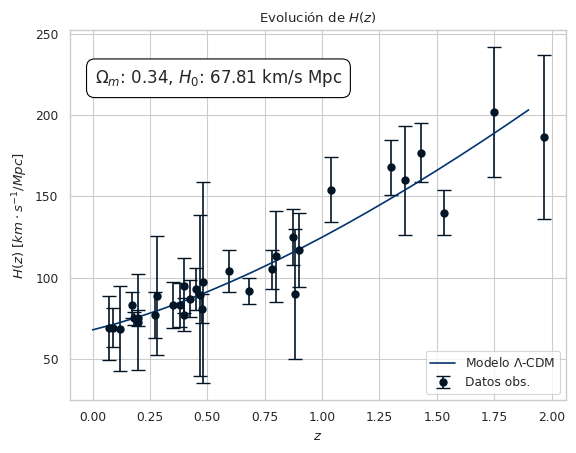

In [34]:
plt.errorbar(redshift,obs, yerr=errors, fmt='o',capsize=5, color='#021526',ms=5, label="Datos obs.")
plt.plot(np.arange(0,2,0.1), ΛCDM_model(chain_ΛCDM[-1])(np.arange(0,2,0.1)), color='#03346E', label=r"Modelo $\Lambda$-CDM")

# Example: Displaying the values of Ω_m and H_0 from chain_ΛCDM[-1]
parameters_text = rf"$\Omega_m$: {chain_ΛCDM[-1][1]:.2f}, $H_0$: {chain_ΛCDM[-1][0]:.2f} km/s Mpc"
plt.text(0.05, 0.9, parameters_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

plt.ylabel("$H(z)$ [$km \\cdot s^{-1}/Mpc$]")
plt.xlabel("$z$")
plt.title("Evolución de $H(z)$")
plt.grid(True)
plt.legend()
plt.savefig("Datos observacionales LCDM")
plt.show()

In [35]:
import seaborn as sns

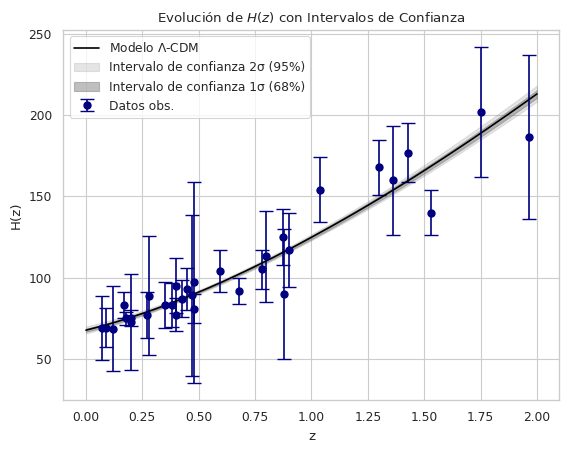

In [36]:
# Generate redshift values for plotting
zvals = np.linspace(0, 2, 100)

# Get model predictions for each sample in the chain (ΛCDM model)
model_predictions = np.array([ΛCDM_model(params)(zvals) for params in chain_ΛCDM])

# Calculate the median and confidence intervals
median_prediction = np.median(model_predictions, axis=0)

# 1σ (68%) interval
lower_1sigma = np.percentile(model_predictions, 16, axis=0)
upper_1sigma = np.percentile(model_predictions, 84, axis=0)

# 2σ (95%) interval
lower_2sigma = np.percentile(model_predictions, 2.5, axis=0)
upper_2sigma = np.percentile(model_predictions, 97.5, axis=0)

# Plot the observational data
plt.errorbar(redshift, obs, yerr=errors, fmt='o', capsize=5, color='navy', label="Datos obs.", ms=5)

# Plot the model's median prediction
plt.plot(zvals, median_prediction, color='black', label=r"Modelo $\Lambda$-CDM")

# Plot the 2σ confidence interval as a shaded region
plt.fill_between(zvals, lower_2sigma, upper_2sigma, color='gray', alpha=0.2, label="Intervalo de confianza 2σ (95%)")

# Plot the 1σ confidence interval as a shaded region
plt.fill_between(zvals, lower_1sigma, upper_1sigma, color='gray', alpha=0.5, label="Intervalo de confianza 1σ (68%)")

# Customize plot
plt.xlabel("z")
plt.ylabel("H(z)")
plt.legend()
plt.title("Evolución de $H(z)$ con Intervalos de Confianza")
plt.grid(True)

# Display the plot
plt.show()


In [37]:
import seaborn as sns
from scipy import stats

In [38]:
def extract_data(chain, index):
    return [chain[i][index] for i in range(len(chain))]

In [39]:
H0_ΛCDM_data, Ωm_ΛCDM_data = extract_data(chain_ΛCDM, 0),  extract_data(chain_ΛCDM, 1)

In [40]:
def create_marginal(x_data, y_data, x_name, y_name):
    sns.set(style="whitegrid", context="paper")
    g = sns.JointGrid(x= x_data, y = y_data)
    g.plot_marginals(sns.histplot, kde=True, color="Blue", bins=30, discrete=False)
    g.plot_joint(sns.kdeplot, fill=True, cmap="Blues", levels=4, thresh=0.0005)
    g.ax_marg_x.axvline(stats.mode(x_data)[0], color="#0C134F", linestyle="--")
    g.ax_marg_y.axhline(stats.mode(y_data)[0], color="#0C134F", linestyle="--")
    g.set_axis_labels(f"${x_name}$", f"${y_name}$", fontsize=14)
    plt.show()

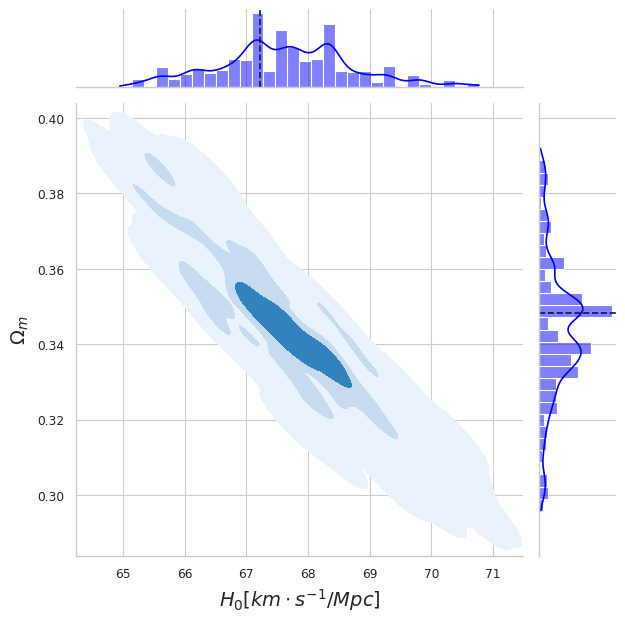

In [42]:
create_marginal(H0_ΛCDM_data, Ωm_ΛCDM_data, "H_0 [km \\cdot s^{-1}/Mpc]", "\\Omega_{m}")

## Modelos alternativos a $\Lambda-CDM$

Una alternativa al modelo de la energía oscura como constante cosmológica es a partir de la ec. de estado en cosmología:
$$ \rho = \frac{p}{\rho} $$

$$w = \frac{p}{\rho} $$

### Modelo CPL

$$ H(z)^{2} = H_{0}^{2}\left(\Omega_m \cdot (1 + z)^3 + (1 - \Omega_m) \cdot (1 + z)^{3(1 + w_0 + w_{a}) \cdot e^{-3w_{a} \left(\frac{z}{z+1}\right)}} \right)$$

In [43]:
#Modelo CPL
def CPL_Model(current_state):
    H_0, Ω_m, w0, w1 = current_state
    def Hz(z):
        inner_expression = Ω_m * (1 + z) ** 3 + (1 - Ω_m)*(1+z)**(3*(1+w0+w1)*np.exp(-3*w1*(z/(z+1))))
        return H_0 * np.sqrt(np.maximum(inner_expression, 0))  # Ensure non-negative
    return Hz

In [44]:
chain_CPL = metropolis_hastings(int(1e4),[70, 0.3,-0.9,0.01], [2.5, 0.25,0.3,0.3], CPL_Model, observed, covariance_matrix)

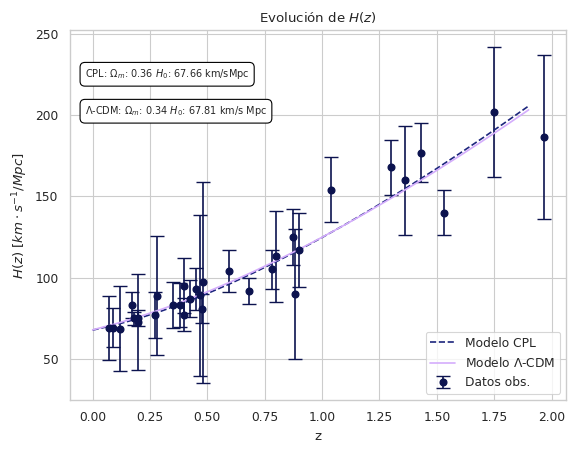

In [45]:
plt.errorbar(redshift, obs, yerr=errors,fmt='o', capsize=5, label="Datos obs.", color="#0C134F")
plt.plot(np.arange(0,2,0.1), CPL_Model(chain_CPL[-1])(np.arange(0,2,0.1)), color='#1D267D',linestyle="--", label=r"Modelo CPL")
plt.plot(np.arange(0,2,0.1), ΛCDM_model(chain_ΛCDM[-1])(np.arange(0,2,0.1)), color='#D4ADFC', label=r"Modelo $\Lambda$-CDM")

# Annotate the chain_CPL[-1] and chain_ΛCDM[-1] values in the plot
parameters_text_CPL = rf"CPL: $\Omega_m$: {chain_CPL[-1][1]:.2f} $H_0$: {chain_CPL[-1][0]:.2f} km/sMpc"
parameters_text_ΛCDM = rf"$\Lambda$-CDM: $\Omega_m$: {chain_ΛCDM[-1][1]:.2f} $H_0$: {chain_ΛCDM[-1][0]:.2f} km/s Mpc"

# Position the text in the plot
plt.text(0.03, 0.9, parameters_text_CPL, transform=plt.gca().transAxes, fontsize=7, 
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))
plt.text(0.03, 0.8, parameters_text_ΛCDM, transform=plt.gca().transAxes, fontsize=7, 
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))

plt.xlabel("z")
plt.ylabel("$H(z)$ [$km \\cdot s^{-1}/Mpc$]")

plt.title("Evolución de $H(z)$")
plt.legend()
plt.grid(True)

plt.savefig("LCDM_CPL_Comparación")
plt.show()

In [46]:
H0_CPL_data, Ωm__CPL_data, w0_CPL_data, w1_CPL_data = [extract_data(chain_CPL,i) for i in range(0,4)]

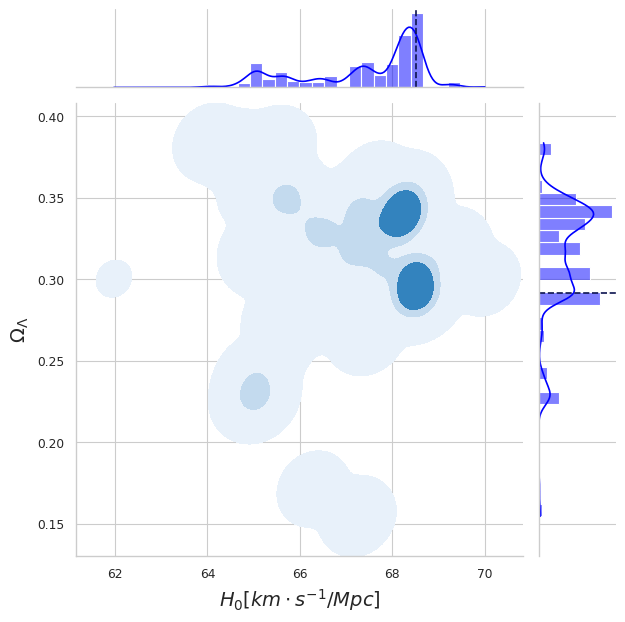

In [47]:
create_marginal(H0_CPL_data, Ωm__CPL_data, "H_0 [km \\cdot s^{-1}/Mpc]", "\\Omega_{\\Lambda}")

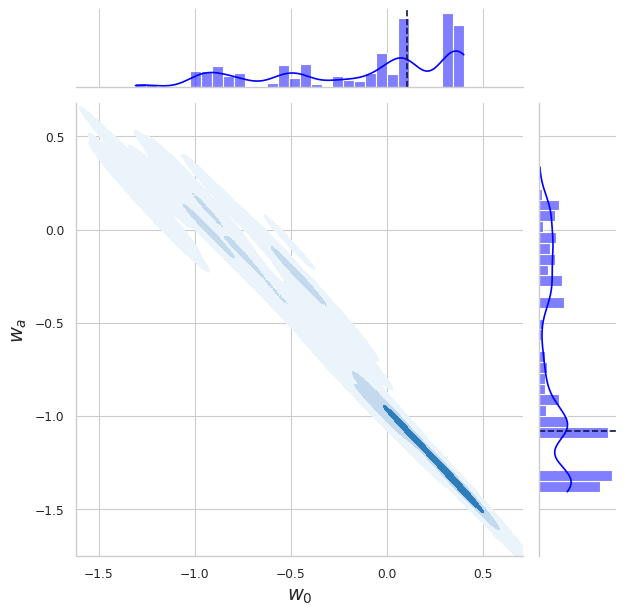

In [48]:
create_marginal(w0_CPL_data, w1_CPL_data, "w_0", "w_a")

In [105]:
w0_CPL_data[-1]
w1_CPL_data[-1]

0.20521060193520183

## Machine Learning

In [ ]:
result = minimize(chi_squared, initial_params, args=()

In [165]:
#Importamos paqueterías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [166]:
data_training = pd.read_csv("/home/usuario/Documents/Proyectos/Energía oscura y Python/hubble_parameter_data_training.txt", sep=' ', header=None)
data_training = data_training.iloc[:,0:3]

In [167]:
z, Hz, errors_Hz = [data_training[i] for i in range(0,3)]

In [182]:
z_train, z_test, Hz_train, z_test = train_test_split(z.values.reshape(-1, 1), Hz.values, test_size=0.2, random_state=42)

In [183]:
nn_model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=100, random_state=42)

In [184]:
nn_model.fit(z_train, Hz_train)

/home/usuario/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=100, random_state=42)

In [92]:
nn_model.compile(optimizer='adam', loss='mean_squared_error')
nn_model.fit(z_train, Hz_train, epochs=100, verbose=1, validation_split=0.1)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 10748.9629 - val_loss: 14884.4131
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 10743.6719 - val_loss: 14877.0898
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 10738.2178 - val_loss: 14869.7998
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 10732.7754 - val_loss: 14862.5312
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 10727.3535 - val_loss: 14855.3291
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 10721.9932 - val_loss: 14848.2002
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 10716.7148 - val_loss: 14841.1484
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 10711.5381 - val_loss: 14834.2627
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 10706.4277 - val_loss: 14827.3516
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 10701.3389 - val_loss: 14820.5049
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 10696.2588 - val_loss:

In [93]:
nn_predictions = nn_model.predict(redshift)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


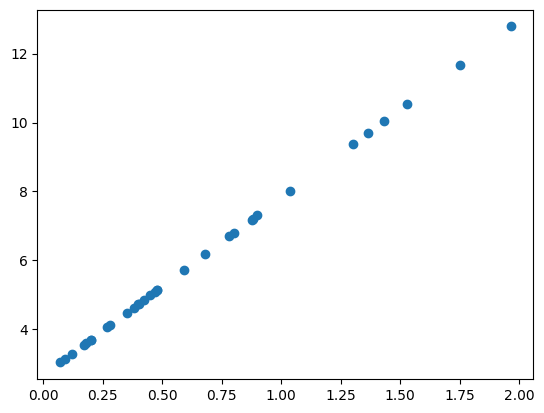

In [95]:
plt.scatter(redshift, nn_predictions)

In [ ]:
def custom_loss(current_state): 
    Hz_pred = ΛCDM_model(current_state)(z)
    return tf.reduce_mean(tf.square(Hz_obs - Hz_pred))

In [34]:
def build_model(hp):
    H0 = hp.Float('H0', min_value=50, max_value=80, step=0.1)
    Ω_m = hp.Float('Om_m', min_value=0.2, max_value=0.4, step=0.01)
    #Om_L = hp.Float('Om_L', min_value=0.6, max_value=0.8, step=0.01)
    
    # No need to define a neural network here, just return the parameters
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Lambda(lambda z: ΛCDM_model([H0,Ω_m])(z) ))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=lambda Hz_obs, z: custom_loss(H0, Om_m, Om_L, z, Hz_obs))
    
    return model

In [30]:
nn_model = MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)
nn_model.fit(z, Hz)
#nn_predictions = nn_model.predict()

ValueError: Expected 2D array, got scalar array instead:
array=0.0.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [33]:
nn_predictions

array([ 94.6984961 , 107.77980468, 191.25445062, 120.49088754,
       177.29744598,  94.8089143 ,  94.1593955 ,  88.3267167 ])

## Referencias

Yu, H., Ratra, B., & Wang, F. Y. (2018). Hubble parameter and Baryon Acoustic Oscillation measurement constraints on the Hubble constant, the deviation from the spatially flat ΛCDM model, the deceleration–acceleration transition redshift, and spatial curvature. The Astrophysical Journal, 856(1), 3.

Bengaly, C., Dantas, M. A., Casarini, L., & Alcaniz, J. (2023). Measuring the Hubble constant with cosmic chronometers: a machine learning approach. The European Physical Journal C, 83(6), 1-13.

Gómez-Vargas, I., Medel-Esquivel, R., García-Salcedo, R., & Vázquez, J. A. (2023). Neural network reconstructions for the Hubble parameter, growth rate and distance modulus. The European Physical Journal C, 83(4), 304.